In [18]:
import pandas as pd
import numpy as np
import re

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

# preprocessing packages
from sklearn.model_selection import train_test_split

# modeling algorithm
import lightgbm as lgb

# model evaluation
from sklearn.metrics import accuracy_score, recall_score, precision_score, \
                            f1_score, roc_auc_score, \
                            classification_report, confusion_matrix

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [5]:
# load training dataset
df = pd.read_parquet('datasets/train_set_features.parquet')

print(f"Shape of dataframe: {df.shape}")
print("")
df.head(3)

Shape of dataframe: (8474661, 11)



user_product_total_purchase  user_total_orders  \
user_id product_id                                                   
1       196                                  10                 10   
        10258                                 9                 10   
        10326                                 1                 10   

                    user_reordered_ratio  user_product_reorder_rate  \
user_id product_id                                                    
1       196                     0.694915                        1.0   
        10258                   0.694915                        0.9   
        10326                   0.694915                        0.1   

                    p_NumOrders  p_NumReorders  p_MedianAddToCartOrder  \
user_id product_id                                                       
1       196               35791          27791                     2.0   
        10258              1946           1389                     3.0   
        10326              5526           3603                     3.0   

                    p_reorder_rate  p_FoodItem  user_product_days_since_order  \
user_id product_id                                                              
1       196               0.776480        True                           30.0   
        10258             0.713772        True                           30.0   
        10326             0.652009        True                           28.0   

                    reordered  
user_id product_id             
1       196               1.0  
        10258             1.0  
        10326             0.0

In [8]:
# cast this boolean column to integers (Yes 1, No 0)
df['p_FoodItem'] = df['p_FoodItem'].astype('int')
df.head(3)

user_product_total_purchase  user_total_orders  \
user_id product_id                                                   
1       196                                  10                 10   
        10258                                 9                 10   
        10326                                 1                 10   

                    user_reordered_ratio  user_product_reorder_rate  \
user_id product_id                                                    
1       196                     0.694915                        1.0   
        10258                   0.694915                        0.9   
        10326                   0.694915                        0.1   

                    p_NumOrders  p_NumReorders  p_MedianAddToCartOrder  \
user_id product_id                                                       
1       196               35791          27791                     2.0   
        10258              1946           1389                     3.0   
        10326              5526           3603                     3.0   

                    p_reorder_rate  p_FoodItem  user_product_days_since_order  \
user_id product_id                                                              
1       196               0.776480           1                           30.0   
        10258             0.713772           1                           30.0   
        10326             0.652009           1                           28.0   

                    reordered  
user_id product_id             
1       196               1.0  
        10258             1.0  
        10326             0.0

In [11]:
# we make note of the imbalanced classes of the target in this dataset
df['reordered'].value_counts(normalize=True)

reordered
0.0    0.9022
1.0    0.0978
Name: proportion, dtype: float64

In [13]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 8474661 entries, (1, 196) to (206209, 48742)
Data columns (total 11 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   user_product_total_purchase    8474661 non-null  int64  
 1   user_total_orders              8474661 non-null  int8   
 2   user_reordered_ratio           8474661 non-null  float64
 3   user_product_reorder_rate      8474661 non-null  float64
 4   p_NumOrders                    8474661 non-null  int64  
 5   p_NumReorders                  8474661 non-null  int64  
 6   p_MedianAddToCartOrder         8474661 non-null  float64
 7   p_reorder_rate                 8474661 non-null  float64
 8   p_FoodItem                     8474661 non-null  int32  
 9   user_product_days_since_order  8474661 non-null  float32
 10  reordered                      8474661 non-null  float64
dtypes: float32(1), float64(5), int32(1), int64(3), int8(1)
memory

#### **Train-test Split**

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
                                 df.drop('reordered', axis=1), df.reordered, test_size=0.2, 
                                 random_state=42, stratify=df.reordered
                                )

#### **LightGBM**

In light of this being a 

In [19]:
# use regular expressions to remove spaces, special characters, etc. in columns
# link for why we've to do this: https://stackoverflow.com/questions/60582050/lightgbmerror-do-not-support-special-json-characters-in-feature-name-the-same
X_train_re = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_test_re = X_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

##### **1.0 Baseline**

In [27]:
# baseline lgb model
lgb_clss = lgb.LGBMClassifier(learning_rate=0.01,
                            n_estimators=1500,
                            num_leaves=100,
                            objective='binary',
                            metrics='f1_macro',
                            random_state=50,
                            n_jobs=-1)
lgb_clss.fit(X_train_re, y_train)
lgb_clss.score(X_test_re, y_test)
preds2 = lgb_clss.predict(X_test_re)
print('Acc Score: ',accuracy_score(y_test, preds2))
print('Roc Auc Score: ',roc_auc_score(y_test, preds2))
print('Precision Score: ',precision_score(y_test, preds2))
print('Recall Score: ',recall_score(y_test, preds2))
print('f1 score: ',f1_score(y_test, preds2))
print('LightGBM confusion matrix on test data  \n', confusion_matrix(y_test, preds2) )
print('_____________________________________________________')
print("")
print('Classification Report  on test data ')
print(classification_report(y_test, preds2))
print('_____________________________________________________')
print("")

[LightGBM] [Info] Number of positive: 663059, number of negative: 6116669
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048905 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1504
[LightGBM] [Info] Number of data points in the train set: 6779728, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.097800 -> initscore=-2.221909
[LightGBM] [Info] Start training from score -2.221909
Acc Score:  0.9071178624759799
Roc Auc Score:  0.5568890350342905
Precision Score:  0.6304783370899073
Recall Score:  0.12149730039513769
f1 score:  0.20373377033923593
LightGBM confusion matrix on test data  
 [[1517364   11804]
 [ 145625   20140]]
_____________________________________________________

Classification Report  on test data 
              precision    recall  f1-score   support

         0.0       0.91      0.99      0

##### **2.0 Adding the** `is_unbalance=True`

In [30]:
lgb_clss = lgb.LGBMClassifier(learning_rate=0.01,
                            n_estimators=1500,
                            num_leaves=100,
                            objective='binary',
                            metrics='f1_macro',
                            random_state=50,
                            n_jobs=-1,
                            is_unbalance=True)
lgb_clss.fit(X_train_re, y_train)
lgb_clss.score(X_test_re, y_test)
preds2 = lgb_clss.predict(X_test_re)
print('Acc Score: ',accuracy_score(y_test, preds2))
print('Roc Auc Score: ',roc_auc_score(y_test, preds2))
print('Precision Score: ',precision_score(y_test, preds2))
print('Recall Score: ',recall_score(y_test, preds2))
print('f1 score: ',f1_score(y_test, preds2))
print('LightGBM confusion matrix on test data  \n', confusion_matrix(y_test, preds2) )
print('_____________________________________________________')
print("")
print('Classification Report  on test data ')
print(classification_report(y_test, preds2))
print('_____________________________________________________')
print("")

[LightGBM] [Info] Number of positive: 663059, number of negative: 6116669
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.109018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1504
[LightGBM] [Info] Number of data points in the train set: 6779728, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.097800 -> initscore=-2.221909
[LightGBM] [Info] Start training from score -2.221909
Acc Score:  0.7344644301574162
Roc Auc Score:  0.7247169161716843
Precision Score:  0.22692239716606347
Recall Score:  0.7125991614635176
f1 score:  0.3442277794533981
LightGBM confusion matrix on test data  
 [[1126744  402424]
 [  47641  118124]]
_____________________________________________________

Classification Report  on test data 
              precision    recall  f1-score   support

         0.0       0.96      0.74      0.83   1529168
         1.0       0.23      0.71      0.34    1657

##### **3.0 Probability Threshold-tuning**

[LightGBM] [Info] Number of positive: 663059, number of negative: 6116669
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.074754 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1504
[LightGBM] [Info] Number of data points in the train set: 6779728, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.097800 -> initscore=-2.221909
[LightGBM] [Info] Start training from score -2.221909


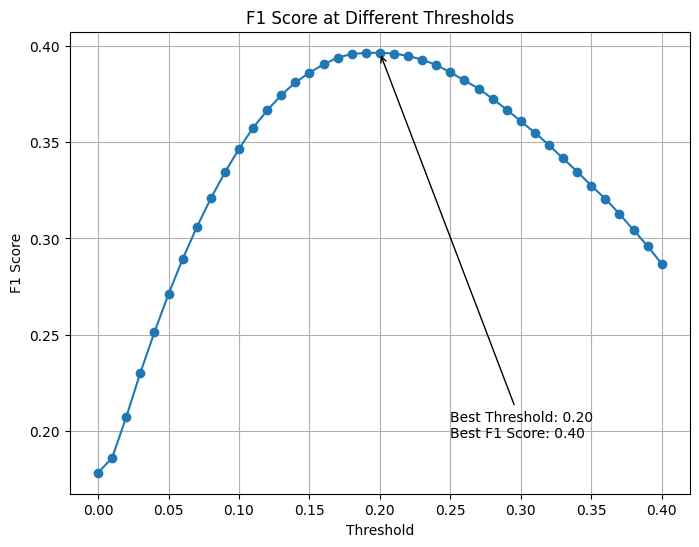

Best Threshold:  0.2
Acc Score:  0.8639598143407439
Roc Auc Score:  0.6826166066678818
Precision Score:  0.350232459261861
Recall Score:  0.4571773293517932
f1 score:  0.3966222422261591
LightGBM confusion matrix on test data  
 [[1388570  140598]
 [  89981   75784]]
_____________________________________________________

Classification Report  on test data 
              precision    recall  f1-score   support

         0.0       0.94      0.91      0.92   1529168
         1.0       0.35      0.46      0.40    165765

    accuracy                           0.86   1694933
   macro avg       0.64      0.68      0.66   1694933
weighted avg       0.88      0.86      0.87   1694933

_____________________________________________________



In [36]:
lgb_clss = lgb.LGBMClassifier(learning_rate=0.01,
                            n_estimators=1500,
                            num_leaves=100,
                            objective='binary',
                            metrics='f1_macro',
                            random_state=50,
                            n_jobs=-1
                            )
lgb_clss.fit(X_train_re, y_train)
lgb_clss.score(X_test_re, y_test)

# Obtain the predicted probabilities for each class on the test set
probs=lgb_clss.predict_proba(X_test_re)

# Define a range of threshold values to try
thresholds = np.arange(0, 0.41, 0.01)

# Initialize variables to store F1 scores
f1_scores = []

# Iterate over the threshold values and evaluate the model's performance
for threshold in thresholds:
    preds = (probs[:, 1] > threshold).astype(int)
    score = f1_score(y_test, preds)
    f1_scores.append(score)

# Find the best threshold and its corresponding F1 score
best_threshold = thresholds[np.argmax(f1_scores)]
best_score = max(f1_scores)

# Plot the F1 scores at different thresholds
plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_scores, marker='o')
plt.title("F1 Score at Different Thresholds")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.grid(True)

# Mark the best threshold on the chart
plt.annotate(f"Best Threshold: {best_threshold:.2f}\nBest F1 Score: {best_score:.2f}",
             xy=(best_threshold, best_score),
             xytext=(best_threshold + 0.05, best_score - 0.2),
             arrowprops=dict(arrowstyle='->'))

# Show the plot
plt.show()

# Use the best threshold to predict the test set and evaluate the model's performance
preds2 = (lgb_clss.predict_proba(X_test)[:,1] > best_threshold).astype(int)

print('Best Threshold: ', best_threshold)
print('Acc Score: ',accuracy_score(y_test, preds2))
print('Roc Auc Score: ',roc_auc_score(y_test, preds2))
print('Precision Score: ',precision_score(y_test, preds2))
print('Recall Score: ',recall_score(y_test, preds2))
print('f1 score: ',f1_score(y_test, preds2))
print('LightGBM confusion matrix on test data  \n', confusion_matrix(y_test, preds2) )
print('_____________________________________________________')
print("")
print('Classification Report  on test data ')
print(classification_report(y_test, preds2))
print('_____________________________________________________')
print("")

#### **Feature Importance**

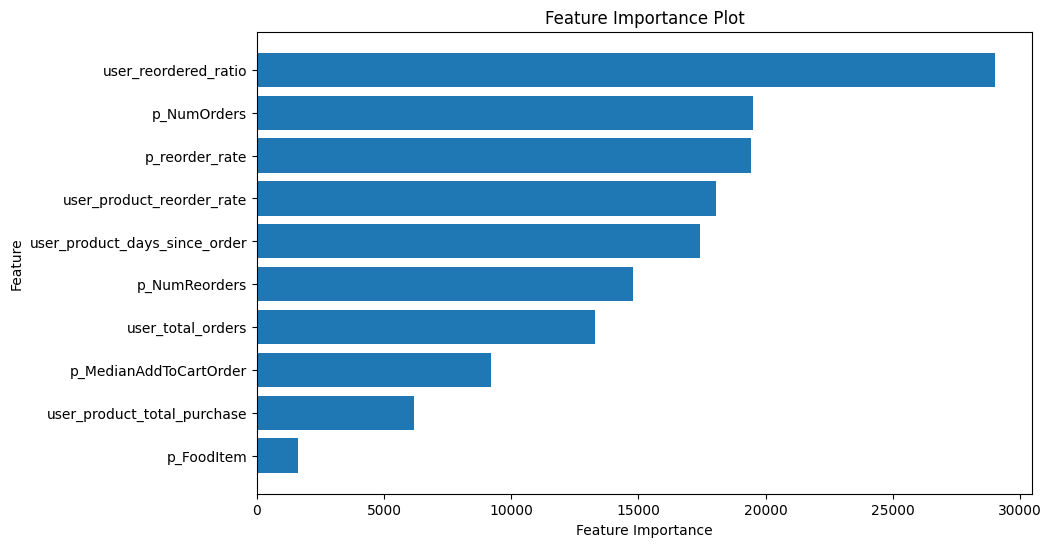

In [38]:
# Get feature importances from the trained LightGBM model
feature_importance = lgb_clss.feature_importances_

# Get the names of the features
feature_names = X_train_re.columns  # Assuming X_train_re is your training data

# Create a DataFrame to store feature names and their corresponding importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Plot')
plt.show()